# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

# Load Datasets

In [5]:
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
categories = pd.read_csv('product_category_name_translation.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv', parse_dates=['review_creation_date', 'review_answer_timestamp'])
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')

# Data Preprocessing

In [6]:
# Check missing values example (for orders)
print("Missing values in orders dataset:\n", orders.isnull().sum())

# Fill missing order_delivered_customer_date with a placeholder (e.g., NaT is fine)
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

# Merge product categories translation
products = products.merge(categories, on='product_category_name', how='left')

# Convert categorical columns to category dtype
categorical_cols = ['order_status', 'payment_type', 'product_category_name_english', 'seller_state', 'customer_state']
for col in categorical_cols:
    if col in orders.columns:
        orders[col] = orders[col].astype('category')
    if col in products.columns:
        products[col] = products[col].astype('category')
    if col in sellers.columns:
        sellers[col] = sellers[col].astype('category')
    if col in customers.columns:
        customers[col] = customers[col].astype('category')

Missing values in orders dataset:
 order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


# Data Integration

In [7]:
# Merge orders with customers
df = orders.merge(customers, on='customer_id', how='left')

# Merge order items + products
order_items_products = order_items.merge(products, on='product_id', how='left')

# Merge df with order items + products
df = df.merge(order_items_products, on='order_id', how='left')

# Merge sellers info
df = df.merge(sellers, on='seller_id', how='left', suffixes=('', '_seller'))

# Merge payments - aggregate payment info (sum payment_value for each order)
payments_agg = payments.groupby('order_id').agg({'payment_value':'sum', 'payment_type':'first', 'payment_installments':'max'}).reset_index()
df = df.merge(payments_agg, on='order_id', how='left', suffixes=('', '_payment'))

# Merge reviews - get review score and comment
df = df.merge(reviews[['order_id', 'review_score']], on='order_id', how='left')

# Exploratory Data Analysis (EDA)

## Total sales over time (monthly)

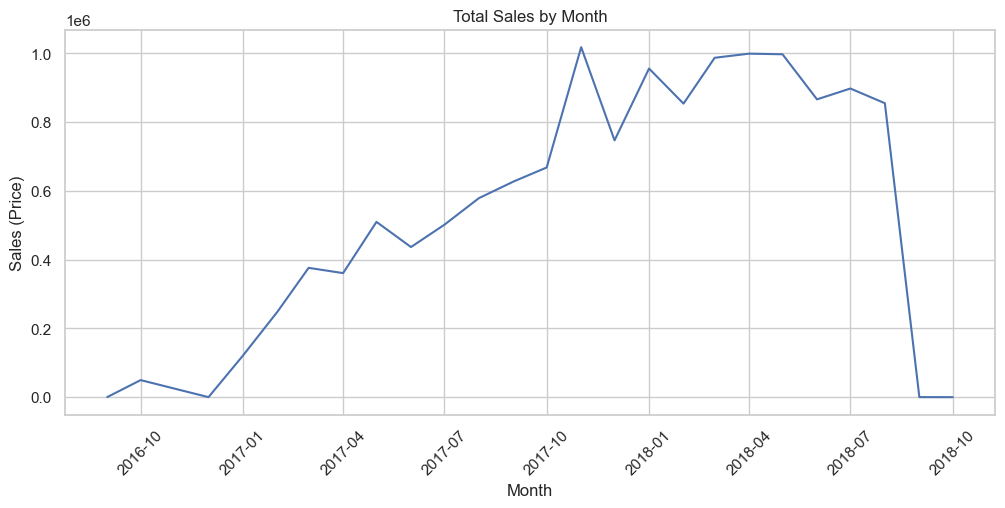

In [17]:
df['order_purchase_month'] = df['order_purchase_timestamp'].dt.to_period('M')
sales_by_month = df.groupby('order_purchase_month')['price'].sum().reset_index()
sales_by_month['order_purchase_month'] = sales_by_month['order_purchase_month'].dt.to_timestamp()

plt.figure(figsize=(12,5))
sns.lineplot(data=sales_by_month, x='order_purchase_month', y='price')
plt.title('Total Sales by Month')
plt.ylabel('Sales (Price)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

## Sales by product category

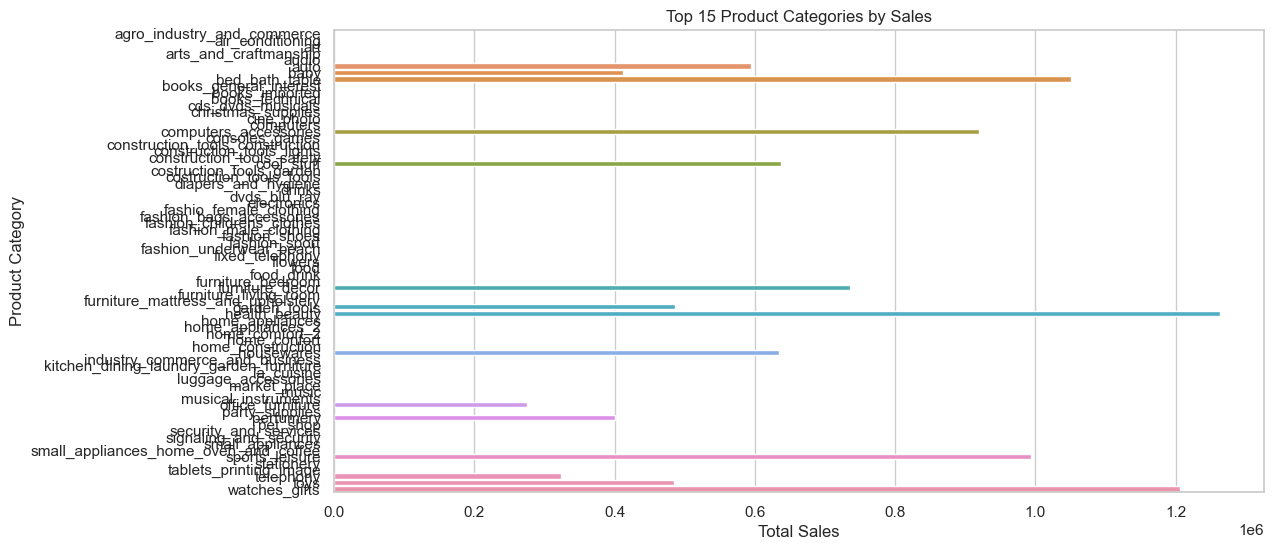

In [9]:
sales_by_category = df.groupby('product_category_name_english')['price'].sum().sort_values(ascending=False).head(15)
plt.figure(figsize=(12,6))
sns.barplot(x=sales_by_category.values, y=sales_by_category.index)
plt.title('Top 15 Product Categories by Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Category')
plt.show()

## Order status distribution

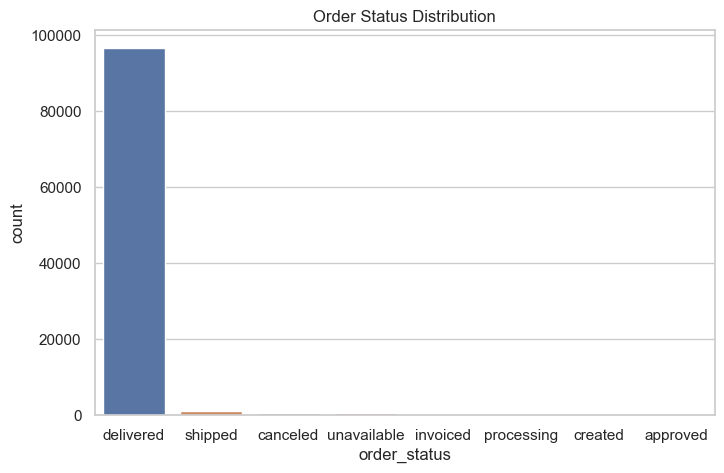

In [10]:
plt.figure(figsize=(8,5))
sns.countplot(data=orders, x='order_status', order=orders['order_status'].value_counts().index)
plt.title('Order Status Distribution')
plt.show()

## Delivery performance - days between estimated and actual delivery

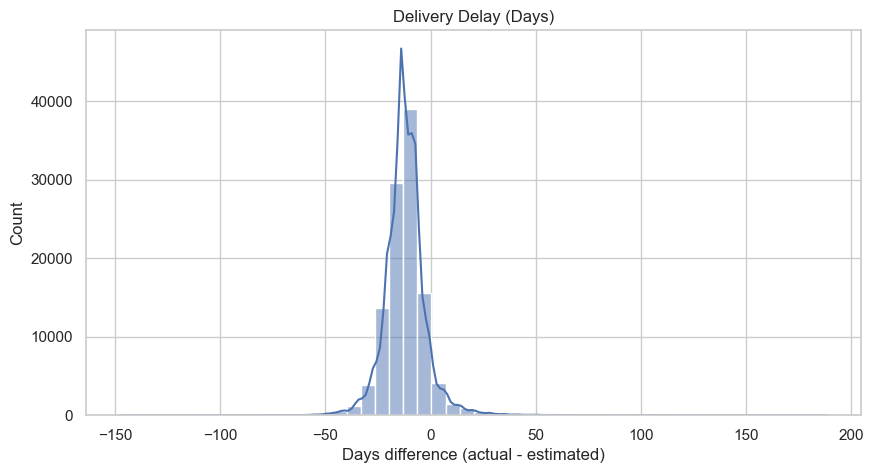

In [11]:
df['delivery_diff_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
plt.figure(figsize=(10,5))
sns.histplot(df['delivery_diff_days'].dropna(), bins=50, kde=True)
plt.title('Delivery Delay (Days)')
plt.xlabel('Days difference (actual - estimated)')
plt.show()

## Customer segmentation example - RFM Analysis

In [12]:
import datetime as dt
snapshot_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

rfm = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'nunique',
    'price': 'sum'
}).reset_index()

rfm.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']

## RFM Score assignment

In [13]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(int)

rfm['RFM_Score'] = rfm['R_Score']*100 + rfm['F_Score']*10 + rfm['M_Score']

## Plot RFM segments count

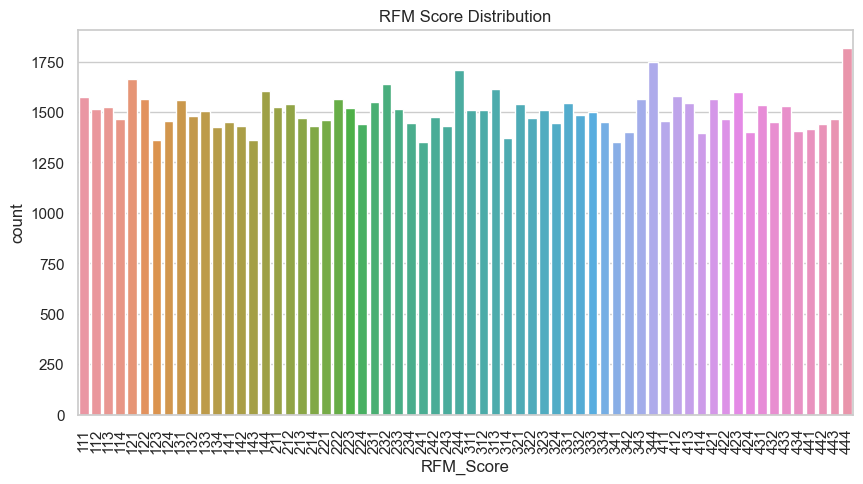

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(x='RFM_Score', data=rfm)
plt.title('RFM Score Distribution')
plt.xticks(rotation=90)
plt.show()

## Review score distribution

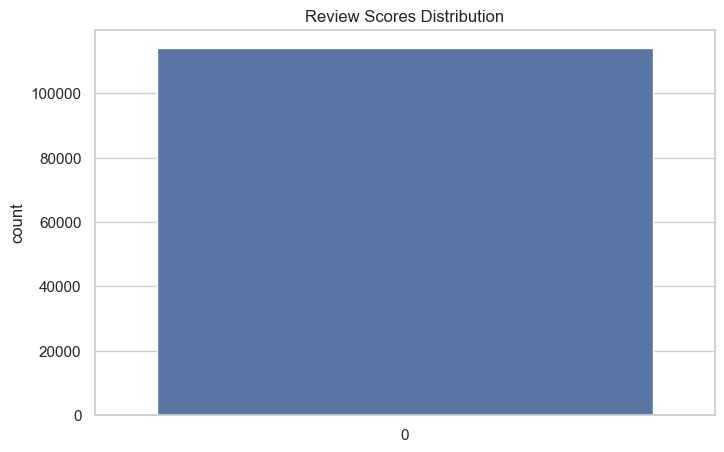

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(df['review_score'])
plt.title('Review Scores Distribution')
plt.show()

# Insights

In [18]:
print("Top product category by sales:", sales_by_category.index[0])
print("Average delivery delay (days):", df['delivery_diff_days'].mean())
print("Average review score:", df['review_score'].mean())
print("Number of unique customers:", df['customer_unique_id'].nunique())
print("Total sales:", df['price'].sum())

Top product category by sales: health_beauty
Average delivery delay (days): -12.035808695495268
Average review score: 4.016997993476589
Number of unique customers: 96096
Total sales: 13651923.469999999
